In [1]:
import timeit
import import_ipynb
from RecombHistory import *
plt.rcParams['font.size'] = 12.0

from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline

# Constants
a_init = 1.0e-8
x_init = np.log(a_init)
x_end = np.log(1.0)

nk = 100
kmin = .1*H0/c
kmax = 1.0e3*H0/c

ks = np.zeros(nk)
for i in range(nk):
    ks[i] = kmin + (kmax - kmin)*(i/100.0)**2.0
    
lmaxint = 6
npar = 6 + lmaxint

n_brec = 500
n_xtot = 1000

importing Jupyter notebook from RecombHistory.ipynb
importing Jupyter notebook from BackgroundCosmology.ipynb
The surface of last scattering occured at x_* = -6.85 and z_* = 938.66.

The half-way point of recombination occured at x_r = -7.12 and z_r = 1238.06.

Using only the Saha equation, the half-way point of recombination occured at x_r = -7.19 and z_r = 1326.77.



In [2]:
'''
print('kmin/max:         ', kmin, kmax)
print('kmin/max no m2Mpc:', 1.0/(η_spline(0.0)[0]), ketamax/(η_spline(0.0)[0]))
xstartrec = -np.log(1.0 + 1630.4)
print('x > x start rec: ', xstartrec)

x = -7.3
print('x init:', x_init)
dτ = τ2spl(x)[0]
hp = getHPrime(x)
print('abs dtau < 10:', abs(dτ))
print('abs ck/hpdt > .1:', abs(c*ketamax/(η_spline(0.0)[0])/(hp*dτ)))
print('ks', ks[-1]/m2Mpc)

x_rr = np.linspace(x_init, x_end, 100, endpoint= True)
for i in range(100):
    dτ = τ2spl(x_rr[i])[0]
    hp = getHPrime(x_rr[i])
    eps = c*ks[-1]/m2Mpc/((hp/m2Mpc/1000.0/100.0)*dτ)
    print('-------------------------------')
    print('i:', i)
    print('x_rr:', x_rr[i])
    
    print('eps =', eps)
    print('tau =', dτ)
    print('xsr =', x_rr[i])
    if (abs(eps) > .1):
        print('~~~~~~eps reached')
    if (abs(dτ) < 10.0):
        print('~~~~~~tau reached')
    if (x_rr[i] > xstartrec):
        print('~~~~~~xsr reached')
    
    
    #print(eps)
    
    if (abs(eps) > .1):
        print('eps =', eps)
    if (abs(dτ) < 10.0):
        print('tau =', dτ)
    if (x < xstartrec):
        print('xsr =', x_rr[i])
    
'''

"\nprint('kmin/max:         ', kmin, kmax)\nprint('kmin/max no m2Mpc:', 1.0/(η_spline(0.0)[0]), ketamax/(η_spline(0.0)[0]))\nxstartrec = -np.log(1.0 + 1630.4)\nprint('x > x start rec: ', xstartrec)\n\nx = -7.3\nprint('x init:', x_init)\ndτ = τ2spl(x)[0]\nhp = getHPrime(x)\nprint('abs dtau < 10:', abs(dτ))\nprint('abs ck/hpdt > .1:', abs(c*ketamax/(η_spline(0.0)[0])/(hp*dτ)))\nprint('ks', ks[-1]/m2Mpc)\n\nx_rr = np.linspace(x_init, x_end, 100, endpoint= True)\nfor i in range(100):\n    dτ = τ2spl(x_rr[i])[0]\n    hp = getHPrime(x_rr[i])\n    eps = c*ks[-1]/m2Mpc/((hp/m2Mpc/1000.0/100.0)*dτ)\n    print('-------------------------------')\n    print('i:', i)\n    print('x_rr:', x_rr[i])\n    \n    print('eps =', eps)\n    print('tau =', dτ)\n    print('xsr =', x_rr[i])\n    if (abs(eps) > .1):\n        print('~~~~~~eps reached')\n    if (abs(dτ) < 10.0):\n        print('~~~~~~tau reached')\n    if (x_rr[i] > xstartrec):\n        print('~~~~~~xsr reached')\n    \n    \n    #print(eps)\n    

In [3]:
# Returns the time at which tight coupling ends.
# Either when (dτ < 10) OR (c*k/(Hp*dt) > .1) OR (x > x(recomb start))
def getTCtime(k):
    xstartrec = -np.log(1.0 + 1630.4)
    x = x_init
    
    while x < xstartrec:
        x = x + 1.0e-2
        
        hp = getHPrime(x)#*Mpc/1.0e3
        dτ = τ2spl(x)[0]
        eps = c*k/(hp*dτ)
        
        if ( (abs(dτ) < 10.0) or (abs(eps) > .1) or (x > xstartrec) ): # ?????
            xtc = x
            break
            
    return xtc

In [4]:
def yTCderivs(x, t):
    dydx = np.zeros(7)
    
    k0 = kcurrent
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    dτ = τ2spl(x)[0]
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*np.exp(x))
    Θ2 = -20.0*c*k0*ytc[6]/(45.0*hp*dτ)
    ψ = -ytc[4] - 12.0*H0**2.0*Ωr*Θ2/(c**2.0*k0**2.0*np.exp(2.0*x))
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # dΦ = [4]
    # θ0 = [5]
    # θ1 = [6]
    
    # dΦ
    dydx[4] = ψ - (c**2.0*k0**2.0*ytc[4]/(3.0*hp**2.0)) + (H0**2.0/(2.0*hp**2.0))*(Ωm*ytc[0]/np.exp(x) + Ωb*ytc[1]/np.exp(x) + 4.0*Ωr*ytc[5]/np.exp(2.0*x))
    
    # dθ0
    dydx[5] = -c*k0*ytc[6]/hp - dydx[4]
    
    q = (-((1.0 - R)*dτ + (1.0 + R)*ddτ)*(3.0*ytc[6] + ytc[3]) - (c*k0/hp)*ψ + (1.0 - dhp/hp)*(c*k0/hp)*(-ytc[5] + 2.0*Θ2) - ((c*k0/hp)*dydx[5]))/((1.0 + R)*dτ + (dhp/hp) - 1.0)
    
    # dvb
    dydx[3] = (-ytc[3] - c*k0*ψ/hp + R*(q + c*k0*(-ytc[5] + 2.0*Θ2)/hp - c*k0*ψ/hp))/(1.0 + R)
    
    #dθ1
    dydx[6] = (q - dydx[3])/3.0
    
    # dv
    dydx[2] = -ytc[2] - c*k0*ψ/hp
    
    # dδ
    dydx[0] = c*k0*ytc[2]/hp - 3.0*dydx[4]
        
    # dδb
    dydx[1] = c*k0*ytc[3]/hp - 3.0*dydx[4]
    
    return dydx

In [5]:
def yderivs(x, t):
    dydx = np.zeros(npar)
    
    a = math.exp(x)
    
    k0 = kcurrent
    
    η = η_spline(x)
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    dτ = τ2spl(x)[0]
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*np.exp(x))
    
    ϵ = (c*k0)/hp
    
    ψ = -y[4] - 12.0*(H0/(c*k0*a))**2.0*Ωr*y[7]
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # Φ  = [4]
    # θ0 = [5]
    # θ1 = [6]
    # Θl = [7->11]
    
    # dΦ
    dydx[4] = ψ - (ϵ**2.0*y[4])/3.0 + (H0**2.0/(2.0*hp**2.0))*(((Ωm*y[0])/a) + ((Ωb*y[1])/a) + ((4.0*Ωr*y[5])/(a**2.0)))
    #dydx[4] = ψ - c**2.0*k0**2.0*y[4]/(3.0*hp**2.0) + (H0**2.0/(2.0*hp**2.0))*(Ωm*y[0]/np.exp(x) + Ωb*y[1]/np.exp(x) + 4.0*Ωr*y[5]/np.exp(2.0*x))
    
    # dδ
    dydx[0] = ϵ*y[2] - 3.0*dydx[4]
    #dydx[0] = c*k0*y[2]/hp - 3.0*dydx[4]

    # dδb
    dydx[1] = ϵ*y[3] - 3.0*dydx[4]
    #dydx[1] = c*k0*y[3]/hp - 3.0*dydx[4]
    
    # dv
    #dydx[2] = -y[2] - c*k0*ψ/hp
    dydx[2] = -y[2] - ϵ*ψ

    # dvb
    #dydx[3] = -y[3] - c*k0*ψ/hp + dτ*R*(3.0*y[6] + y[3])
    dydx[3] = -y[3] - ϵ*ψ + dτ*R*(3.0*y[6] + y[3])
    
    # dθ0
    #dydx[5] = -c*k0*y[6]/hp - dydx[4]
    dydx[5] = -ϵ*y[6] - dydx[4]

    # dθ1
    #dydx[6] = c*k0*y[5]/(3.0*hp) - 2.0*c*k0/(3.0*hp)*y[7] + c*k0*ψ/(3.0*hp) + dτ*(y[6] + (1.0/3.0)*y[3])
    dydx[6] = (ϵ/3.0)*y[5] - (2.0*ϵ/3.0)*y[7] + (ϵ/3.0)*ψ + dτ*(y[6] + (1.0/3.0)*y[3])
    
    # dθ2
    dydx[7] = (2.0*ϵ/5.0)*y[6] - (3.0/5.0)*ϵ*y[8] + dτ*(y[7] -.1*y[7])
    
    # dΘ2->5
    #for l in range(2, lmaxint):
    #    dydx[5 + l] = l*c*k0*y[5 + l - 1]/((2.0*l + 1.0)*hp) - (l + 1.0)*c*k0*y[5 + l + 1]/((2.0*l + 1.0)*hp) + dτ*(y[5 + l] -(1.0/10.0)*y[7])
    for l in range(3, lmaxint):
        dydx[5 + l] = ((l*ϵ*y[5 + l - 1])/(2.0*l + 1.0)) - (((l + 1.0)*ϵ*y[5 + l + 1])/((2.0*l + 1.0))) + (dτ*y[5 + l])
    
    
    # dΘ6
    dydx[npar - 1] = ϵ*y[npar - 2] - ((c*(lmaxint + 1.0)*y[npar - 1])/(hp*η)) + (dτ*y[npar - 1])
    #dydx[npar - 1] = c*k0*y[npar - 2]/hp - c*(lmaxint + 1)*y[npar - 1]/(hp*η) + dτ*y[npar - 1]
    
    return dydx

In [6]:
def yderivs_C_l(x, y):
    dydx = np.zeros(npar)
    
    k0 = kcurrent
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    dτ = τ2spl(x)[0]
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*math.exp(x))
    ψ = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*k0**2.0*np.exp(2.0*x))
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # Φ  = [4]
    # θ0 = [5]
    # θ1 = [6]
    # Θl = [7->11]
    
    # dΦ
    dydx[4] = ψ - c**2.0*k0**2.0*y[4]/(3.0*hp**2.0) + (H0**2.0/(2.0*hp**2.0))*(Ωm*y[0]/np.exp(x) + Ωb*y[1]/np.exp(x) + 4.0*Ωr*y[5]/np.exp(2.0*x))
    
    # dδ
    dydx[0] = c*k0*y[2]/hp - 3.0*dydx[4]

    # dδb
    dydx[1] = c*k0*y[3]/hp - 3.0*dydx[4]
    
    # dv
    dydx[2] = -y[2] - c*k0*ψ/hp

    # dvb
    dydx[3] = -y[3] - c*k0*ψ/hp + dτ*R*(3.0*y[6] + y[3])
    
    # dθ0
    dydx[5] = -c*k0*y[6]/hp - dydx[4]

    # dθ1
    dydx[6] = c*k0*y[5]/(3.0*hp) - 2.0*c*k0/(3.0*hp)*y[7] + c*k0*ψ/(3.0*hp) + dτ*(y[6] + (1.0/3.0)*y[3])
    
    # dΘ2->5
    for l in range(2, lmaxint):
        dydx[5 + l] = l*c*k0*y[5 + l - 1]/((2.0*l + 1.0)*hp) - (l + 1.0)*c*k0*y[5 + l + 1]/((2.0*l + 1.0)*hp) + dτ*(y[5 + l] -(1.0/10.0)*y[7])
    
    # dΘ6
    dydx[npar - 1] = c*k0*y[npar - 2]/hp - c*(lmaxint + 1)*y[npar - 1]/(hp*η_spline(x)) + dτ*y[npar - 1]
    
    return dydx

In [7]:
'''
def source_function():
    S = np.zeros(shape = (n_grid, nk))
    
    for i in range(n_grid):
        g = gspl(x_grid[i])[0]
        dg = g2spl(x_grid[i])[0]
        ddg = g22spl(x_grid[i])[0]
        τ = τspl(x_grid[i])[0]
        dτ = τ2spl(x_grid[i])[0]
        ddτ = τ22spl(x_grid[i])[0]
        hp = getHPrime(x_grid[i])
        dhp = getdHPrime(x_grid[i])
        ddhhp = .5*H0**2.0*((Ωb + Ωm)/np.exp(x_grid[i]) + 4.0*Ωr/np.exp(2.0*x_grid[i]) + 4.0*ΩΛ*np.exp(2.0*x_grid[i]))
    
        for j in range(nk):
            Π = Θ[n_grid + i, 2, j]
            dΠ = dΘ[i, 2, j]
            ddΠ = .4*c*ks[j]*(-dhp*Θ[n_grid + i, 1, j]/hp + dΘ[i, 1, j])/hp + .3*(ddτ*Π + dτ*dΠ) - (.6*c*ks[j]/hp)*((-dhp/hp)*Θ[n_grid + i, 3, j] + dΘ[i, 3, j])
            
            part1 = g*(Θ[n_grid + i, 0, j] + Ψ[n_grid + i, j] + Π/4.0)
            part2 = np.exp(-τ)*(dΨ[i, j] - dΦ[i, j])
            part3 = -(1.0/(c*ks[j]))*(g*vb[n_grid + i, j]*dhp + g*hp*dvb[i, j] + hp*vb[n_grid + i, j]*dg)
            part4 = ((3.0/4.0)/(c**2.0*ks[j]**2.0))*(ddhhp*g*Π + 3.0*hp*dhp*(dg*Π + g*dΠ) + hp**2.0*(ddg*Π + 2.0*dg*dΠ + g*ddΠ))
            
            S[i, j] = part1 + part2 + part3 + part4
        
    ks_high_res = np.exp(np.linspace(np.log(kmin), np.log(kmax), num=n_high_res))
        
    xstartrec = -np.log(1.0 + 1630.4)
    x_grid_high_res = np.linspace(xstartrec, x_end, n_high_res, endpoint=True)
        
        
    S_spl = RectBivariateSpline(x_grid_high_res, ks_high_res, S)
        
    return S_spl, x_high_res, ks_high_res
'''

'\ndef source_function():\n    S = np.zeros(shape = (n_grid, nk))\n    \n    for i in range(n_grid):\n        g = gspl(x_grid[i])[0]\n        dg = g2spl(x_grid[i])[0]\n        ddg = g22spl(x_grid[i])[0]\n        τ = τspl(x_grid[i])[0]\n        dτ = τ2spl(x_grid[i])[0]\n        ddτ = τ22spl(x_grid[i])[0]\n        hp = getHPrime(x_grid[i])\n        dhp = getdHPrime(x_grid[i])\n        ddhhp = .5*H0**2.0*((Ωb + Ωm)/np.exp(x_grid[i]) + 4.0*Ωr/np.exp(2.0*x_grid[i]) + 4.0*ΩΛ*np.exp(2.0*x_grid[i]))\n    \n        for j in range(nk):\n            Π = Θ[n_grid + i, 2, j]\n            dΠ = dΘ[i, 2, j]\n            ddΠ = .4*c*ks[j]*(-dhp*Θ[n_grid + i, 1, j]/hp + dΘ[i, 1, j])/hp + .3*(ddτ*Π + dτ*dΠ) - (.6*c*ks[j]/hp)*((-dhp/hp)*Θ[n_grid + i, 3, j] + dΘ[i, 3, j])\n            \n            part1 = g*(Θ[n_grid + i, 0, j] + Ψ[n_grid + i, j] + Π/4.0)\n            part2 = np.exp(-τ)*(dΨ[i, j] - dΦ[i, j])\n            part3 = -(1.0/(c*ks[j]))*(g*vb[n_grid + i, j]*dhp + g*hp*dvb[i, j] + hp*vb[n_grid + i,

In [8]:
Θ = np.zeros(shape=(n_xtot, lmaxint, nk))
dΘ = np.zeros(shape=(n_t, lmaxint, nk))

δ = np.zeros(shape=(n_xtot, nk))
δb = np.zeros(shape=(n_xtot, nk))

v = np.zeros(shape=(n_xtot, nk))
vb = np.zeros(shape=(n_xtot, nk))
dvb = np.zeros(shape=(n_t, nk))

Φ = np.zeros(shape=(n_xtot, nk))
dΦ = np.zeros(shape=(n_t, nk))

Ψ = np.zeros(shape=(n_xtot, nk))
dΨ = np.zeros(shape=(n_t, nk))

# Set up initial conditions for Boltzmann and Einstein equations
for i in range(nk):
    
    Φ[0, i] = 1.0
    
    δ[0, i] = (3.0/2.0)*Φ[0, i]
    δb[0, i] = (3.0/2.0)*Φ[0, i]
    
    v[0, i] = c*ks[i]*Φ[0, i]/(2.0*getHPrime(x_init))
    vb[0, i] = v[0, i]
    
    Θ[0, 0, i] = (1.0/2.0)*Φ[0, i]
    Θ[0, 1, i] = -c*ks[i]*Φ[0, i]/(6.0*getHPrime(x_init))
    Θ[0, 2, i] = -20.0*c*ks[i]*Θ[0, 1, i]/(45.0*getHPrime(x_init)*τ2spl(x_init)[0])
    
    for l in range(3, lmaxint):
        Θ[0, l, i] = -(l/(2.0*l + 1.0))*(c*ks[i]/(getHPrime(x_init)*τ2spl(x_init)[0]))*Θ[0, l - 1, i]
        
    #Ψ[0, i] = -1.0#-Φ[0, i] - 12.0*Ωr*Θ[0, 2, i]*H0/(c*ks[i]*np.exp(x_init))
    Ψ[0, i] = -Φ[0, i] - 12.0*(H0/(c*ks[i]*a_init))**2.0*Ωr*Θ[0, 2, i]
    
    '''
    Ψ[0, i] = -1.0/(3.0/2.0)
    Φ[0, i] = -Ψ[0, i]
    
    δ[0, i] = (-3.0/2.0)*Ψ[0, i]
    δb[0, i] = δ[0, i]
    
    v[0, i] = -c*ks[i]*Ψ[0, i]/(2.0*getHPrime(x_init))
    vb[0, i] = v[0, i]
    
    Θ[0, 0, i] = (-1.0/2.0)*Ψ[0, i]
    Θ[0, 1, i] = c*ks[i]*Ψ[0, i]/(6.0*getHPrime(x_init))
    
    Θ[0, 2, i] = -20.0*c*ks[i]*Θ[0, 1, i]/(45.0*getHPrime(x_init)*τ2spl(x_init)[0])
    
    for l in range(3, lmaxint):
        Θ[0, l, i] = -l*c*ks[i]*Θ[0, l - 1, i]/((2.0*l + 1.0)*getHPrime(x_init)*τ2spl(x_init)[0])
    '''

In [56]:
ntight = 500

dx_brec = (x_t[0] - x_init)/(n_brec - 1.0)
x_brec = [x_init + (i - 1.0)*dx_brec for i in range(n_brec)]

x_tot = np.zeros(n_xtot)

x_tot[0:n_brec] = x_brec[0:n_brec]
x_tot[(n_brec):n_xtot] = x_t[0:n_brec]
print(len(x_tot))
print(x_tot[n_brec-1])
print(x_tot[n_brec])
print(x_tot[n_brec+1])
print(x_tot[(n_brec-3):(n_brec+3)])
print(x_brec[0], x_brec[-1])
print(x_t[0], x_t[-1])
print(x_brec[0], x_brec[-1], xtc)

1000
-7.424175891603191
-7.402094556558315
-7.39719382086648
[-7.46833856 -7.44625723 -7.42417589 -7.40209456 -7.39719382 -7.39229309]
-18.442762078997244 -7.424175891603191
-7.402094556558315 -0.02140649139397155
-18.442762078997244 -7.424175891603191 -12.0


In [48]:
start = timeit.default_timer()

y = np.zeros(npar)
ytc = np.zeros(7) #y tight coupling - ytc

x_grid = np.linspace(x_init, x_end, n_xtot)

# Propogate each k-mode independently
for k in range(nk):
    kcurrent = ks[k]
    
    ytc[0] = δ[0, k]
    ytc[1] = δb[0, k]
    ytc[2] = v[0, k]
    ytc[3] = vb[0, k]
    ytc[4] = Φ[0, k]
    ytc[5] = Θ[0, 0, k]
    ytc[6] = Θ[0, 1, k]
    
    # Find the time at which tight couplint (TC) is assumed
    #  and integrate equations to that time
    #xtc = getTCtime(kcurrent)
    #if ((np.abs(xtc) - np.abs(x_t[0])) < 1.0e-3):
    #    xtc = x_t[0]
    #xtc = -7.601402334583733
    
    
    if k < 26:
        xtc = -15.0
    elif (k > 25) and (k < 51):
        xtc = -14.0
    elif (k > 50) and (k < 76):
        xtc = -13.0
    elif (k > 75):
        xtc = -12.0
    else:
        xtc = -12.0
    
    xtight = np.linspace(x_init, xtc, ntight)
    x_full = np.linspace(xtc, x_end, 1000 - ntight, endpoint=True)
    
    if k%20==0:
        print('------------------------------')
        print('k:', k)
        print('xtc:', xtc)
        
    sol_tight = solve_ivp(yTCderivs, [x_brec[0], x_brec[-1]], ytc, t_eval=x_brec, rtol=1e-11, atol=1e-11)#t_eval=x_brec[x_brec < xtc]
    
    y_after_tc = sol_tight.y[:, -1]
    
    for i in range(1, n_brec):
        δ[i, k] = sol_tight.y[0, i]
        δb[i, k] = sol_tight.y[1, i]
        v[i, k] = sol_tight.y[2, i]
        vb[i, k] = sol_tight.y[3, i]
        Φ[i, k] = sol_tight.y[4, i]
        Θ[i, 0, k] = sol_tight.y[5, i]
        Θ[i, 1, k] = sol_tight.y[6, i]
        Θ[i, 2, k] = -20.0*c*kcurrent*Θ[i, 1, k]/(45.0*getHPrime(x_brec[i])*τ2spl(x_brec[i])[0])
        for l in range(3, lmaxint):
            Θ[i, l, k] = -(l/(2.0*l + 1.0))*(c*kcurrent/(getHPrime(x_brec[i])*τ2spl(x_brec[i])[0]))*Θ[i, l - 1, k]
            
        Ψ[i, k] = -Φ[i, k] - 12.0*(H0/(c*kcurrent*np.exp(x_brec[i])))**2.0*Ωr*Θ[i, 2, k]
    
    for j in range(7):
        y[j] = y_after_tc[j]
        
    # Θ2
    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*τ2spl(x_brec[-1])[0])
    
    for l in range(2, lmaxint):
        #y[6 + l] = -(l/(2.0*l + 1.0))*(c*kcurrent/(getHPrime(x_tot[n_brec + 1]*τ2spl(x_tot[n_brec + 1])[0]))*y[4 + l]
        y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(x_brec[-1])*τ2spl(x_brec[-1])[0])*Θ[i, l - 1, k]
        
    sol_full = solve_ivp(yderivs, [x_t[0], x_t[-1]], y, t_eval=x_t, rtol=1e-11, atol=1e-11)
    
    '''
    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*τ2spl(xtc)[0])
    
    for l in range(2, lmaxint):
        y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*τ2spl(xtc)[0])
    '''
    
    for i in range(n_t):
        δ[n_brec + i, k] = sol_full.y[0, i]
        δb[n_brec + i, k] = sol_full.y[1, i]
        v[n_brec + i, k] = sol_full.y[2, i]
        vb[n_brec + i, k] = sol_full.y[3, i]
        Φ[n_brec + i, k] = sol_full.y[4, i]
        Ψ[n_brec + i, k] = -Φ[n_brec + i, k] - 12.0*(H0/(c*kcurrent*math.exp(x_t[i])))**2.0*Ωr*Θ[n_brec + i, 2, k]
        #Ψ[n_brec + i, k] = -Φ[n_brec + 1, k] - 12.0*H0**2.0*Ωr*sol_full.y[7, i]/(c**2.0*kcurrent**2.0*math.exp(2.0*x_t[i]))
        
        for l in range(lmaxint):
            Θ[n_brec + i, l, k] =  sol_full.y[6 + l - 1, i]
            
    for i in range(len(x_full)):
        
        deriv_C_ls = yderivs_C_l(x_full[i], y)

        dΦ[i, k] = deriv_C_ls[4]
        dvb[i, k] = deriv_C_ls[3]
        dΘ[i, :, k] = deriv_C_ls[6:npar]
        dΨ[i, k] = -dΦ[0, k] + 12.0*H0**2.0*Ωr*Θ[i, 2, k]/(c**2.0*kcurrent**2.0*np.exp(2.0*x_full[i]))
    
    '''
    cur_δ = np.concatenate((sol_tight.y[0], sol_full.y[0]))
    cur_δb = np.concatenate((sol_tight.y[1], sol_full.y[1]))
    cur_v = np.concatenate((sol_tight.y[2], sol_full.y[2]))
    cur_vb = np.concatenate((sol_tight.y[3], sol_full.y[3]))
    cur_Φ = np.concatenate((sol_tight.y[4], sol_full.y[4]))
    cur_Θ0 = np.concatenate((sol_tight.y[5], sol_full.y[5]))
    cur_Θ1 = np.concatenate((sol_tight.y[6], sol_full.y[6]))
    
    δ[:, k] = cur_δ
    δb[:, k] = cur_δb
    v[:, k] = cur_v
    vb[:, k] = cur_vb
    Φ[:, k] = cur_Φ
    Θ[:, 0, k] = cur_Θ0
    Θ[:, 1, k] = cur_Θ1
    '''
    
stop = timeit.default_timer()
print('Time:', stop - start)

δ_spl = RectBivariateSpline(x_tot, ks, δ)
δb_spl = RectBivariateSpline(x_tot, ks, δb)
v_spl = RectBivariateSpline(x_tot, ks, v)
vb_spl = RectBivariateSpline(x_tot, ks, vb)
Φ_spl = RectBivariateSpline(x_tot, ks, Φ)
Ψ_spl = RectBivariateSpline(x_tot, ks, Ψ)
Θ0_spl = RectBivariateSpline(x_tot, ks, Θ[:, 0, :])
Θ1_spl = RectBivariateSpline(x_tot, ks, Θ[:, 1, :])
Θ2_spl = RectBivariateSpline(x_tot, ks, Θ[:, 2, :])

------------------------------
k: 0
xtc: -15.0


BackgroundCosmology.ipynb:7: RuntimeWarning: overflow encountered in exp
  "outputs": [],
BackgroundCosmology.ipynb:10: RuntimeWarning: overflow encountered in exp
  "import numpy as np\n",
BackgroundCosmology.ipynb:10: RuntimeWarning: invalid value encountered in double_scalars
  "import numpy as np\n",
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
BackgroundCosmology.ipynb:10: RuntimeWarning: overflow encountered in double_scalars
  "import numpy as np\n",
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


------------------------------
k: 20
xtc: -15.0
------------------------------
k: 40
xtc: -14.0
------------------------------
k: 60
xtc: -13.0
------------------------------
k: 80
xtc: -12.0
Time: 40.16727549999996


In [15]:
def plot(kvals):
    #kmpc = '{:.3g}'.format(kval*(1.0e6*3.08567758e16))
    #data_δ = δ_spl(x_grid, kval)[:, 0]
    #data_δb = δb_spl(x_grid, kval)[:, 0]
    #data_v = v_spl(x_grid, kval)[:, 0]
    #data_vb = vb_spl(x_grid, kval)[:, 0]
    #data_Φ = Φ_spl(x_grid, kval)[:, 0]
    #data_Ψ = Ψ_spl(x_grid, kval)[:, 0]
    #data_Θ0 = Θ0_spl(x_grid, kval)[:, 0]
    #data_Θ1 = Θ1_spl(x_grid, kval)[:, 0]
    #data_Θ2 = Θ2_spl(x_grid, kval)[:, 0]
    
    clr = ['r', 'b', 'g', 'k']
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(17, 16))
    
    axs[0, 0].set_title('Density Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 0].set_yscale('log')
    axs[0, 0].set_xlim(-16, 0)
    axs[0, 0].set_ylim(1.0e-3, 1.2e4)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.4f}'.format(kvals[i]*Mpc)) + '/Mpc'
        
        data_δ = δ_spl(x_tot, kvals[i])[:, 0]
        axs[0, 0].plot(x_tot, np.abs(data_δ), color=clr[i], label=lb)
        
        data_δb = δb_spl(x_tot, kvals[i])[:, 0]
        axs[0, 0].plot(x_tot, np.abs(data_δb), color=clr[i], ls='--')
    #plt.plot(x_grid, np.abs(3.0*data_Θ0), label='δR')
    axs[0, 0].set_xlabel('x = ln(a)')
    axs[0, 0].set_ylabel('δ')
    axs[0, 0].legend()
    
    
    axs[0, 1].set_title('Evolution of Velocity Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 1].set_yscale('log')
    axs[0, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        
        data_v = v_spl(x_tot, kvals[i])[:, 0]
        axs[0, 1].plot(x_tot, np.abs(data_v), color=clr[i], label=lb)
        
        data_vb = vb_spl(x_tot, kvals[i])[:, 0]
        axs[0, 1].plot(x_tot, np.abs(data_vb), color=clr[i], ls='--')
        
        data_Θ1 = Θ1_spl(x_tot, kvals[i])[:, 0]
        axs[0, 1].plot(x_tot, -3.0*data_Θ1, color=clr[i], ls=':')
    #plt.plot(x_grid, np.abs(-3.0*data_Θ1),label='|vR|')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('$v_{CDM}$ (solid), $v_{b}$ (dashed), $v_{\gamma}$ = -3$Θ_1$ (dotted)')
    axs[0, 1].legend()
    
    
    axs[1, 0].set_title('Evolution of Effective Photon Temperature Perturbation')
    axs[1, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Θ0 = Θ0_spl(x_tot, kvals[i])[:, 0]
        data_Ψ = Ψ_spl(x_tot, kvals[i])[:, 0]
        axs[1, 0].plot(x_tot, data_Θ0 + data_Ψ, color=clr[i], label=lb)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('$Θ^{eff}$ = $Θ_0$ + Ψ')
    axs[1, 0].legend()
    
    axs[1, 1].set_title('Ψ')
    axs[1, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Ψ = Ψ_spl(x_tot, kvals[i])[:, 0]
        axs[1, 1].plot(x_tot, data_Ψ, color=clr[i], label=lb)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('Ψ')
    axs[1, 1].legend()
    
    axs[2, 0].set_title('Evolution of the Newtonian Potential')
    axs[2, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Φ = Φ_spl(x_tot, kvals[i])[:, 0]
        axs[2, 0].plot(x_tot, data_Φ, color=clr[i], label=lb)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('Φ')
    axs[2, 0].legend()
    
    axs[2, 1].set_title('Evolution of the Anistropic Stress')
    axs[2, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Ψ = Ψ_spl(x_tot, kvals[i])[:, 0]
        data_Φ = Φ_spl(x_tot, kvals[i])[:, 0]
        axs[2, 1].plot(x_tot, data_Ψ + data_Φ, color=clr[i], label=lb)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('Φ + Ψ')
    axs[2, 1].legend()
    
    fig.tight_layout()
    plt.show()

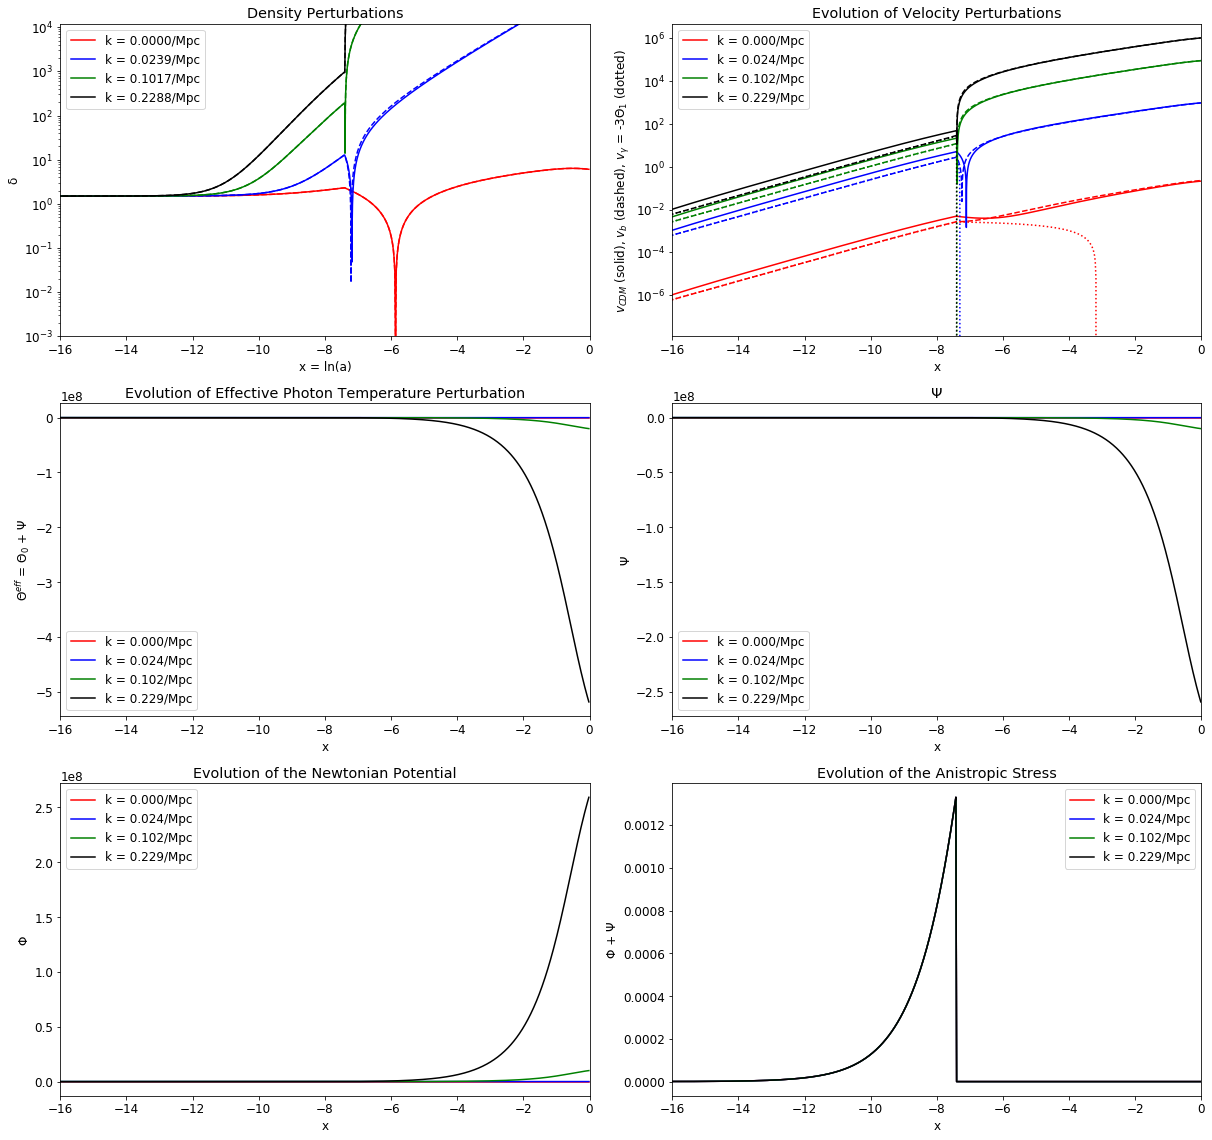

In [18]:
#kvals = [.0001, .001, .01, .1]
k_factor = 1.0#*(1.0e6*3.08567758e16)
kvals = [ks[0]*k_factor, ks[32]*k_factor, ks[66]*k_factor, ks[-1]*k_factor]
plot(kvals)

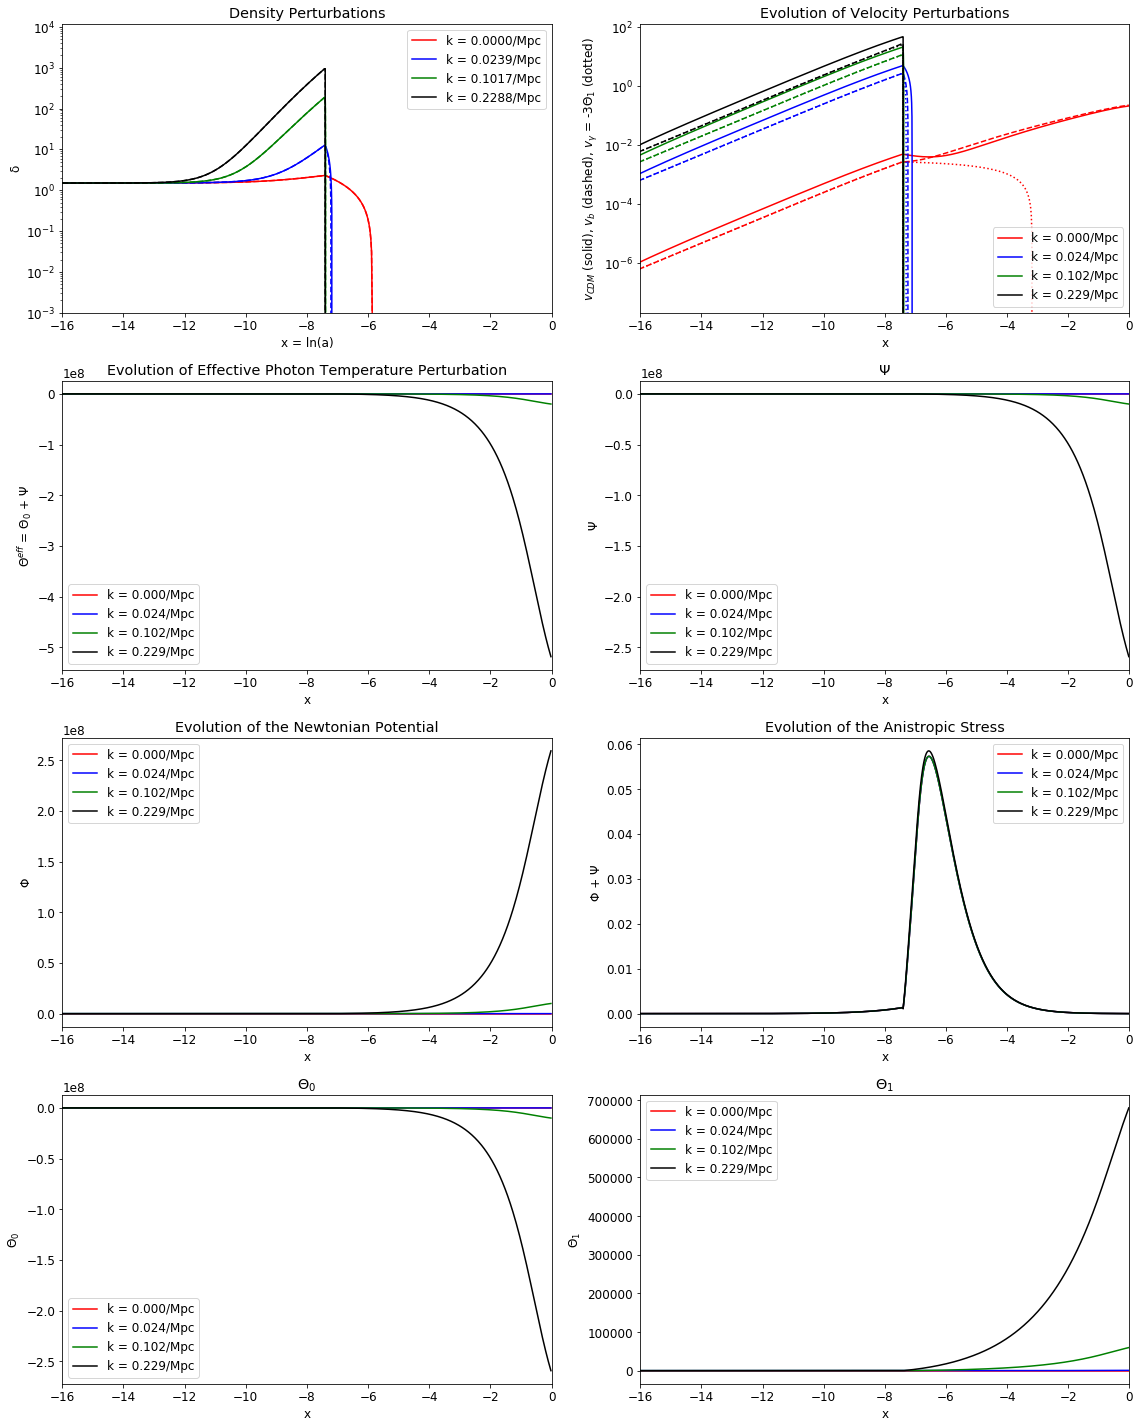

In [53]:
def plot(kvals):
    clr = ['r', 'b', 'g', 'k']
    
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
    
    
    kv = [0, 32, 66, 99]
    axs[0, 0].set_title('Density Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 0].set_yscale('log')
    axs[0, 0].set_xlim(-16, 0)
    axs[0, 0].set_ylim(1.0e-3, 1.2e4)
    
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.4f}'.format(kvals[i]*Mpc)) + '/Mpc'
        #data_δ = δ_spl(x_tot, kvals[i])[:, 0]
        #axs[0, 0].plot(x_tot, np.abs(data_δ), color=clr[i], label=lb)
        axs[0, 0].plot(x_tot, δ[:, kv[i]], color=clr[i], label=lb)
        
        #data_δb = δb_spl(x_tot, kvals[i])[:, 0]
        #axs[0, 0].plot(x_tot, np.abs(data_δb), color=clr[i], ls='--')
        axs[0, 0].plot(x_tot, δb[:, kv[i]], color=clr[i], ls='--')
    axs[0, 0].set_xlabel('x = ln(a)')
    axs[0, 0].set_ylabel('δ')
    axs[0, 0].legend()
    
    
    axs[0, 1].set_title('Evolution of Velocity Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 1].set_yscale('log')
    axs[0, 1].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        
        #data_v = v_spl(x_tot, kvals[i])[:, 0]
        #axs[0, 1].plot(x_tot, np.abs(data_v), color=clr[i], label=lb)
        axs[0, 1].plot(x_tot, v[:, kv[i]], color=clr[i], label=lb)
        
        #data_vb = vb_spl(x_tot, kvals[i])[:, 0]
        #axs[0, 1].plot(x_tot, np.abs(data_vb), color=clr[i], ls='--')
        axs[0, 1].plot(x_tot, vb[:, kv[i]], color=clr[i], ls='--')
        
        #data_Θ1 = Θ1_spl(x_tot, kvals[i])[:, 0]
        #axs[0, 1].plot(x_tot, -3.0*data_Θ1, color=clr[i], ls=':')
        axs[0, 1].plot(x_tot, -3.0*Θ[:, 1, kv[i]], color=clr[i], ls=':')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('$v_{CDM}$ (solid), $v_{b}$ (dashed), $v_{\gamma}$ = -3$Θ_1$ (dotted)')
    axs[0, 1].legend()
    
    
    axs[1, 0].set_title('Evolution of Effective Photon Temperature Perturbation')
    axs[1, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Θ0 = Θ0_spl(x_tot, kvals[i])[:, 0]
        data_Ψ = Ψ_spl(x_tot, kvals[i])[:, 0]
        axs[1, 0].plot(x_tot, data_Θ0 + data_Ψ, color=clr[i], label=lb)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('$Θ^{eff}$ = $Θ_0$ + Ψ')
    axs[1, 0].legend()
    
    axs[1, 1].set_title('Ψ')
    axs[1, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Ψ = Ψ_spl(x_tot, kvals[i])[:, 0]
        axs[1, 1].plot(x_tot, data_Ψ, color=clr[i], label=lb)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('Ψ')
    axs[1, 1].legend()
    
    axs[2, 0].set_title('Evolution of the Newtonian Potential')
    axs[2, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Φ = Φ_spl(x_tot, kvals[i])[:, 0]
        #axs[2, 0].plot(x_tot, Φ[:, kv[i]], color=clr[i], label=lb)
        axs[2, 0].plot(x_tot, data_Φ, color=clr[i], label=lb)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('Φ')
    axs[2, 0].legend()
    
    axs[2, 1].set_title('Evolution of the Anistropic Stress')
    axs[2, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Ψ = Ψ_spl(x_tot, kvals[i])[:, 0]
        data_Φ = Φ_spl(x_tot, kvals[i])[:, 0]
        axs[2, 1].plot(x_tot, data_Ψ + data_Φ, color=clr[i], label=lb)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('Φ + Ψ')
    axs[2, 1].legend()
    
    axs[3, 0].set_title('$Θ_0$')
    axs[3, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Θ0 = Θ0_spl(x_tot, kvals[i])[:, 0]
        axs[3, 0].plot(x_tot, data_Θ0, color=clr[i], label=lb)
    axs[3, 0].set_xlabel('x')
    axs[3, 0].set_ylabel('$Θ_0$')
    axs[3, 0].legend()
    
    axs[3, 1].set_title('$Θ_1$')
    axs[3, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Θ1 = Θ1_spl(x_tot, kvals[i])[:, 0]
        axs[3, 1].plot(x_tot, data_Θ1, color=clr[i], label=lb)
    axs[3, 1].set_xlabel('x')
    axs[3, 1].set_ylabel('$Θ_1$')
    axs[3, 1].legend()
    
    
    
    fig.tight_layout()
    plt.show()
    
#kvals = [.0001, .001, .01, .1]
k_factor = 1.0#*(1.0e6*3.08567758e16)
kvals = [ks[0]*k_factor, ks[32]*k_factor, ks[66]*k_factor, ks[-1]*k_factor]
#kvals = [.0001/Mpc, .001/Mpc, .01/Mpc, .1/Mpc]
plot(kvals)

In [14]:
'''
def plot(kvals):
    clr = ['r', 'b', 'g', 'k']
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(17, 16))
    
    axs[0, 0].set_title('Density Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 0].set_yscale('log')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.4f}'.format(kvals[i])) + '/Mpc'
        
        data_δ = δ_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, data_δ, color=clr[i], label=lb)
        
        data_δb = δb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(data_δb), color=clr[i], ls='--')
        
        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(3.0*data_Θ0), color=clr[i], ls=':')
    axs[0, 0].set_xlabel('x = ln(a)')
    axs[0, 0].set_ylabel('δ')
    axs[0, 0].legend()
    
    
    axs[0, 1].set_title('Velocity Perturbations')
    axs[0, 1].set_yscale('log')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        
        data_v = v_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_v), color=clr[i], label=lb)
        
        data_vb = vb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_vb), color=clr[i], ls='--')
        
        data_Θ1 = Θ1_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(-3.0*data_Θ1), color=clr[i], ls=':')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('$v_{CDM}$ (solid), $v_{b}$ (dashed), $v_{\gamma}$ = -3$Θ_1$ (dotted)')
    axs[0, 1].legend()
    
    
    axs[1, 0].set_title('Evolution of Effective Photon Temperature Perturbation')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]
        axs[1, 0].plot(x_grid, data_Θ0 + data_Ψ, color=clr[i], label=lb)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('$Θ^{eff}$ = $Θ_0$ + Ψ')
    axs[1, 0].legend()
    
    axs[1, 1].set_title('Ψ')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        axs[1, 1].plot(x_grid, data_Ψ, color=clr[i], label=lb)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('Ψ')
    axs[1, 1].legend()
    
    axs[2, 0].set_title('Evolution of the Newtonian Potential')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 0].plot(x_grid, data_Φ, color=clr[i], label=lb)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('Φ')
    axs[2, 0].legend()
    
    axs[2, 1].set_title('Evolution of the Anistropic Stress')
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i])) + '/Mpc'
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 1].plot(x_grid, data_Ψ + data_Φ, color=clr[i], label=lb)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('Φ + Ψ')
    axs[2, 1].legend()
    
    fig.tight_layout()
    plt.show()
    
kvals = [ks[0]*m2Mpc, ks[32]*m2Mpc, ks[66]*m2Mpc, ks[-1]*m2Mpc]
plot(kvals)
'''

"\ndef plot(kvals):\n    clr = ['r', 'b', 'g', 'k']\n    \n    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(17, 16))\n    \n    axs[0, 0].set_title('Density Perturbations')# k = ' + str(kmpc) + '/ Mpc')\n    axs[0, 0].set_yscale('log')\n    for i in range(len(kvals)):\n        lb = 'k = ' + str('{:05.4f}'.format(kvals[i])) + '/Mpc'\n        \n        data_δ = δ_spl(x_grid, kvals[i])[:, 0]\n        axs[0, 0].plot(x_grid, data_δ, color=clr[i], label=lb)\n        \n        data_δb = δb_spl(x_grid, kvals[i])[:, 0]\n        axs[0, 0].plot(x_grid, np.abs(data_δb), color=clr[i], ls='--')\n        \n        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]\n        axs[0, 0].plot(x_grid, np.abs(3.0*data_Θ0), color=clr[i], ls=':')\n    axs[0, 0].set_xlabel('x = ln(a)')\n    axs[0, 0].set_ylabel('δ')\n    axs[0, 0].legend()\n    \n    \n    axs[0, 1].set_title('Velocity Perturbations')\n    axs[0, 1].set_yscale('log')\n    for i in range(len(kvals)):\n        lb = 'k = ' + str('{:05.3f}'.format(kva